# MACID codebase demonstration

This Notebook will introduce the main features of the codebase and is structured as follows:
1. Instantiating and plotting a simple single-decision CID.
2. Determining if a node faces an information incentive from graphical criteria in a single-agent CID (Everitt et al.(2019b) and (Carey et al., 2020))

3. Other single-decision CID incentives.
4. Instantiating a simple MACID.
5. Generating the relevance graph of a MACID.
6. More complicated MACID graphs 
7. Identifying reasoning patterns in MACIDs:
8. Computing Nash Equilibria (acyclic relevance graph):
9. Computing Nash Equilibria (cyclic relevance graph):
10. Transforming MACIDs into EFGs for use with __[GAMBIT](http://www.gambit-project.org/)__


In [1]:
#importing necessary libraries
%autosave 60
import numpy as np
from cpd import NullCPD
%matplotlib inline
import matplotlib.pyplot as plt
from macid import MACID

Autosaving every 60 seconds


### 1) Instantiating and plotting a simple single-decision CID.

<div class="alert alert-block alert-info">
<b>Definition:</b> 
A <b>Causal influence Diagram (CID)</b> (Everitt et al, 2019) is a tuple $(\textbf{V}, E, \Theta)$  where:
    
   - $(\textbf{V}, E)$ is a directed acyclic graph with a set of vertices $\textbf{V}$ connected by directed edges $E \subseteq \textbf{V} \times \textbf{V}$. 
 
 These vertices are partitioned into:
    
    - $\textbf{D} \subseteq \textbf{V}$ is a set of decision nodes represented by rectangles.
        
    - $\textbf{U} \subseteq \textbf{V} \setminus \textbf{D}$ is a set of utility nodes represented by diamonds and utility nodes have no successors.
        
    - $\textbf{X} \subseteq \textbf{V} \setminus (\textbf{D} \cup \textbf{U})$ is the set of chance nodes represented by ovals.
      
- $\Theta$ is a parameterisation over the nodes in the CID specifying:
    
     - A finite domain $dom(V)$ for each node $V \in \textbf{V}$.
        
     - Real-valued domains $dom(U) \subset \mathbb{R}$ for all utility nodes $U \in \textbf{U}$.
        
     - A set of conditional probability distributions (CPDs), $\Pr(\textbf{V} \mid pa_V$), for every chance and utility node $\textbf{X} \cup \textbf{U} \in \textbf{V}$. Taken together, these form a partial distribution $\Pr(\textbf{X},\textbf{U} : \textbf{D}) = \prod_{V \in \textbf{V} \setminus \textbf{D}} \Pr(V | Pa_V)$ over the variables in the CID.
        
     - The value of a utility node $u \in dom(U)$ is a deterministic function of the values of its parents $pa_U \in dom(Pa_U)$. So, for each instantiation $pa_U$, one value of $U$ has probability 1 and all other values of $U$ have probability 0.
        
</div>    

Therefore, if we only care about the CID's graph (and not its parametrisation), we need only specify:
- the graph's nodes and edges 
- a partitioning of all nodes into decision, utility and chance nodes.

Our first example is taken from Everitt et al (2019)'s "Understanding Agent Incentives using
Causal Influence Diagrams":

__Fitness Tracker Example:__ _A machine learning systemis  recommending  calorie  intake  (decision)  to  optimizethe user’s fitness (utility). The optimal calorie intake de-pends on the person’s physical activity, which cannot be measured directly. Instead, the decision must be based on a step count provided by a fitness tracker. The tracker designer developed the software behind the tracker firmware of the fitness counter's step counter._ 

- TD = Tracker designer
- TF = Tracker firmware
- SC = Step count
- EF = Estimation Formula
- EWD = Estimated Walking Distance
- P = Physical activity
- D = Dirty clothes
- C = Reccomended calorie intake (decision node)
- F = Fitness (utility node)

In [2]:
def fitness_tracker():
    macid = MACID([
        ('TD', 'TF'),  #defining the graph's nodes and edges
        ('TF', 'SC'),
        ('TF', 'C'),
        ('EF', 'EWD'),
        ('EWD', 'C'),
        ('C', 'F'),
        ('P', 'D'),
        ('P', 'SC'),
        ('P', 'F'),
        ('SC', 'C'),
        ],
        #a nested dictionary classifying that there are 7 chance nodes and 1 agent with decision node 'C' and utility node 'F'
        {1: {'D': ['C'], 'U': ['F']}, 'C': ['TD', 'EF', 'EWD', 'D', 'P', 'TF', 'SC']})  
        
    return macid
    

We now instantiate this MACID's graph

In [3]:
cid = fitness_tracker()

We call the macid class' method "draw" to plot this single-agent CID. Decision variables are denoted by blue rectangles, utilty nodes by yellow diamonds, and chance nodes by gray circles.

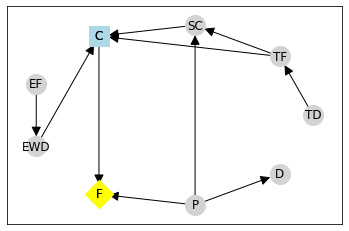

In [4]:
cid.draw()

### 2) Determining if a node faces an information incentive in a single-agent CID

A variable has __positive value of information (VoI)__ if a decision-maker would benefit from knowing its value before making a decision.

Its graphical criteria is:

>A single-decision CID admits __positive value of information__ for $X\in\textbf{V}$ if and only if:
1. $X \notin D$
2. $X \notin Desc(D)$
3. $U\in Desc(D)$
4. $X \not\perp U | (Pa_D ∪ {D} \setminus {X})$

To determine which nodes have positive value of information for the agent making the decision at node 'C':

In [5]:
cid.all_info_inc_nodes(1)  #The argument '1' specifies that we are about the incentives of the agent labelled '1'.

['TF', 'SC', 'P', 'D']

Therefore, the agent would like to know the outcome of "Tracker firmware', 'Step count', 'Physical activity' and 'Dirty clothes' before deciding what calorie intake to recommend.

We can also identify whether the agent has an information incentive for an individual node:

In [6]:
cid.has_info_inc('P',1)

True

In [7]:
cid.has_info_inc('TD',1)

False

### 3) Other single-decision CID incentives:

These examples are taken from Carey et al (2020) "The Incentives that Shape Behaviour"

__Accident prediction example:__ _An AI system of an insurance company predicts the likelihood that a propsective client will have a recorded car accident. They would like the system to carry out accurate predictions without treating clients differently based on their marital status, age, or country of birth._

- B = Country of birth
- N = Nationality
- P = Profiling
- M = Marital status
- Racc = Recorded Accident
- Age = Age
- Adt = Accident
- AP = Accident Prediction (decision node)
- F = Accuracy (utility node)

In [8]:
def car_accident_predictor():
    from pgmpy.factors.discrete.CPD import TabularCPD
    macid = MACID([
        ('B', 'N'),
        ('N', 'AP'),
        ('N', 'P'),
        ('P', 'Racc'),
        ('Age', 'Adt'),
        ('Adt', 'Racc'),
        ('Racc', 'Accu'),
        ('M', 'AP'),
        ('AP', 'Accu'),
        ],
        {1: {'D': ['AP'],'U': ['Accu']}, 'C': ['B', 'N', 'P', 'Racc', 'Adt', 'Age', 'M']},     #defines the decisions, chance nodes and utility nodes for each agent
        )     

    return macid

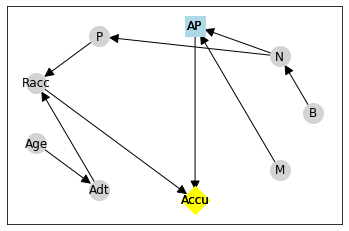

In [9]:
cid2 = car_accident_predictor()
cid2.draw()

A __nonrequisite observation link__ in a single-decision CID G is any edge $W \rightarrow D,D\in \textbf{D}$ such that $W \perp U | (Pa_D ∪ {D} \setminus {W})$.
(where $U\in Desc(D)$)

>The __reduced graph G∗__ of a single-decision CID G is the result of removing from G all nonrequisite observation links.

A variable has a __response incentive__ if a decision-maker benefits from making its decision causally responsive to the variable.

Its graphical criterion is:

>A single-decision CID G admits a __response incentive__ on $X \in \textbf{V}$ if and only if the reduced graph G∗ has a directed path $X \rightarrow D$.

In [10]:
cid2.all_response_inc_nodes(1)

['B', 'N']

In [11]:
cid2.all_info_inc_nodes(1)

['N', 'P', 'Racc', 'Age', 'Adt']

We have idenitified which nodes admit positive value of information and/or a response incentive. 

Carey et al (2020) argued that the undesired response incentive for country of birth indicates an incentive for counterfactual unfairness (Kusner et al, 2017).

__Content recommendation example:__ _An AI algorithm has the task of recommending a se23 ries of posts to a user. The designers want the posts to match the user’s interests, to maximise the number of posts the user clicks on. However, they want the algorithm not to present polarising content that would manipulate the user, in order to attract more clicks_

- O = Original user opinions
- I = Influences user opinions
- M = Model of original opinions
- P = Posts to show (decision node)
- C = Clicks (utility node)

In [12]:
def content_recommender():
    from pgmpy.factors.discrete.CPD import TabularCPD
    macid = MACID([
        ('O', 'I'),
        ('O', 'M'),
        ('M', 'P'),
        ('P', 'I'),
        ('I', 'C'),
        ('P', 'C'),
        ],
        {1: {'D': ['P'],'U': ['C']}, 'C': ['O', 'M', 'I']},     #defines the decisions, chance nodes and utility nodes for each agent
        )     

    return macid

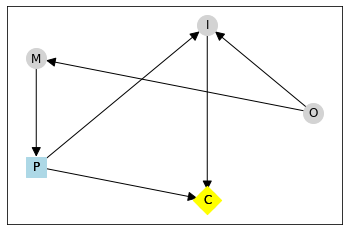

In [13]:
cid3 = content_recommender()
cid3.draw()

A variable has positive value of control (VoC) if a decision-maker could benefit from choosing that variable's value.

Its graphical criterion is:

>A single-decision CID G admits __positive value of control__ for a node $X \in V \setminus {D}$ if and only if there is a directed path $X \rightarrow U$ in the reduced graph G∗.

In [14]:
cid3.all_control_inc_nodes(1)

['O', 'I', 'M', 'C']

A variable has a __feasible control incentive__ if the agent’s actual control of that variable can influence its performance. 

Its graphical criterion is:

>A single-decision CID G admits a __feasible control incentive__ on $X \in V$ if and only if G has a directed path from the decision $D$ to a utility node $U \in \textbf{U}$ that passes through $X$ (i.e. a directed path $D \rightarrow X \rightarrow U$).

In [15]:
cid3.all_feasible_control_inc_nodes(1)

['I', 'C']

Carey et al (2020) argue that becasue there is a feasible control incentive on influenced user opinion, the agent may seek to change the value of that variable in order to attain utility. This seems problematic. However, if the system is redisgned as below, the incentives that are present become less problematic

In [16]:
def modified_content_recommender():
    from pgmpy.factors.discrete.CPD import TabularCPD
    macid = MACID([
        ('O', 'I'),
        ('O', 'M'),
        ('M', 'P'),
        ('P', 'I'),
        ('P', 'C'),
        ('M', 'C')
        ],
        {1: {'D': ['P'],'U': ['C']}, 'C': ['O', 'M', 'I']},     #defines the decisions, chance nodes and utility nodes for each agent
        )     

    return macid

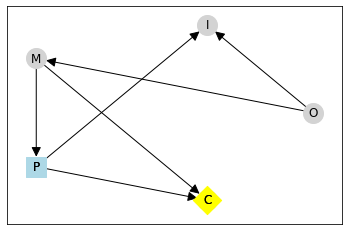

In [17]:
cid4 = modified_content_recommender()
cid4.draw()

In the CID modified content recommender, 'C' now stands for 'predicted clicks'.

### 4) Instantiating a simple MACID

<div class="alert alert-block alert-info">
<b>Definition:</b> 
A <b>multi-agent causal influence diagram (MACID)</b> $\mathcal{M}$ is a tuple $(N, \textbf{V}, E, \Theta)$ where:
- $N = \{1,...,n\}$ is a set of players
- $(\textbf{V}, E, \Theta)$ defines a CID, but now the decision and utility nodes $\textbf{D}$ and $\textbf{U}$ are partitioned into sets $\textbf{D} = \{\textbf{D}^1, ..., \textbf{D}^n\}$ and $\textbf{U} = \{\textbf{U}^1, ..., \textbf{U}^n\}$. Each agent $i \in N$ is associated with only the decision and utility nodes in sets $\textbf{D}^i$ and $\textbf{U}^i$. 

Note: Unless otherwise indicated we index mathematical objects with superscripts $i \in N$ to denote their affiliation with player $i$ and with subscripts $j \in \mathbb{N}$ to enumerate over a specific player's decisions or utilities.
        
</div>   

In [18]:
def simple_sequential():
    from pgmpy.factors.discrete.CPD import TabularCPD
    macid = MACID([
        ('D1', 'D2'),
        ('D1', 'U1'),
        ('D1', 'U2'),
        ('D2', 'U2'),
        ('D2', 'U1'),
        ],
        {1: {'D': ['D1'], 'U': ['U1']}, 2: {'D': ['D2'], 'U': ['U2']}, 'C': []})  #each agent has their own utility and decision nodes

    return macid

Macids' graphs are instantiated in the same way as before, but we now have more than one agent. Here, we have defined a simple 2-player sequential game.

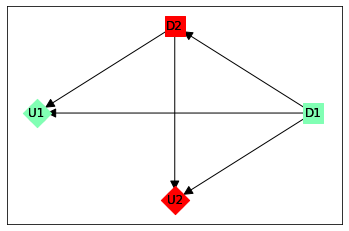

In [19]:
macid = simple_sequential()
macid.draw()

Decision and utility nodes are square and diamond shaped respectively. The nodes belonging to each agent are coloured uniquely. 

In [20]:
def simple_simultaneous():
    from pgmpy.factors.discrete.CPD import TabularCPD
    macid = MACID([
        ('D1', 'U1'),
        ('D1', 'U2'),
        ('D2', 'U2'),
        ('D2', 'U1'),
        ],
        {1: {'D': ['D1'], 'U': ['U1']}, 2: {'D': ['D2'], 'U': ['U2']}, 'C': []})

    return macid

This is an example of a simple 2-player simultaneous game (eg prisoner's dilemma)

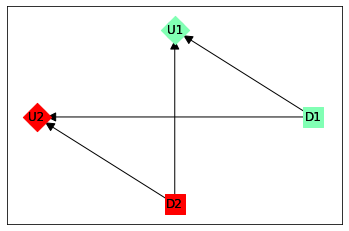

In [21]:
macid2 = simple_simultaneous()
macid2.draw()

### 5) Generating the relevance graph of a MACID:

In order to find in order to find the optimal policy for a single decision variable, we often need to already know the optimal policy for other decision variables. This is captured by the idea of "strategic relevance". 
(see my technical report for details - link here)

The directed __relevance graph__ for $\mathcal{M}$, denoted by $Rel(\mathcal{M}) = (\textbf{D}, E_{Rel})$, is a graph where $\textbf{D}$ is the set of $\mathcal{M}$'s decision nodes connected by directed edges $E_{Rel} \subseteq \textbf{D} \times \textbf{D}$. There is a directed edge from $D_m \rightarrow D_l$ if and only if $D_m$ is strategically relevant for $D_l$. It is helpful to think of the directed edges in $Rel(\mathcal{M})$ as pointing in the direction of ‘relevance’; a child node in the relevance graph (strategically) relies on it’s ancestors.

Note: the edge directions used here are the same as in (Koller, 2003) but reversed compared with those in (Koller, 2001).

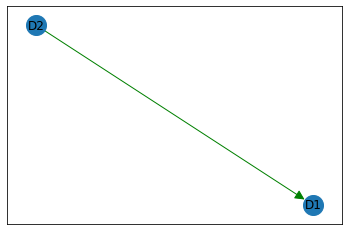

<Figure size 432x288 with 0 Axes>

In [22]:
macid.draw_strategic_rel_graph()

We deliberatly use a different display style to make clear the distinction between the macid and its relevance graph.

The relevance graph for this simple sequential game is acyclic. Since player 2 can observe the value of $D1$, player 2 does not need to know player1’s  policy  before  deciding  on  the  best  policy  for D2. However, player 1 does strategically rely on 2’s policy for D2. Therefore, to compute the overall best response policy profile, we iterate through the relevance graph’s node ordering. We decide the best policy for D2 first, before then optimising the policy for D1.

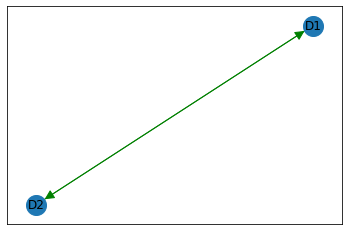

<Figure size 432x288 with 0 Axes>

In [23]:
macid2.draw_strategic_rel_graph()

The relevance graph for the simultaneous game is cyclic because each decision node strategically relies on the other one in order to optimise its own utility. For instance, in a prisoner's dilemma, each prisoner would want to know the action of the other prisoner before deciding on its own policy.

### 6) More complicated MACID graphs:

In this section, we show some more complicated macids as well as their relevance graphs

We first recreate the "tree killer" example from Koller and Milch (2001) "Multi-agent influence diagrams for representing and solving games"

In [24]:
def tree_killer():
    from pgmpy.factors.discrete.CPD import TabularCPD
    macid = MACID([
        ('PT', 'E'),
        ('PT', 'TS'),
        ('PT', 'BP'),
        ('TS', 'TDoc'),
        ('TS', 'TDead'),
        ('TDead', 'V'),
        ('TDead', 'Tree'),
        ('TDoc', 'TDead'),
        ('TDoc', 'Cost'),
        ('TDoc', 'BP'),
        ('BP', 'V'),
        ],
        {0: {'D': ['PT', 'BP'], 'U': ['E', 'V']}, 1: {'D': ['TDoc'], 'U': ['Tree', 'Cost']}, 'C': ['TS', 'TDead']},     #defines the decisions, chance nodes and utility nodes for each agent
        )      

    return macid

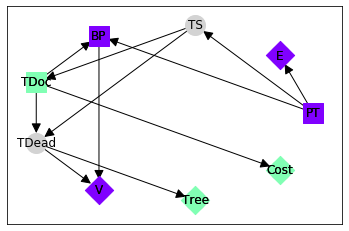

In [25]:
macid3 = tree_killer()
macid3.draw()

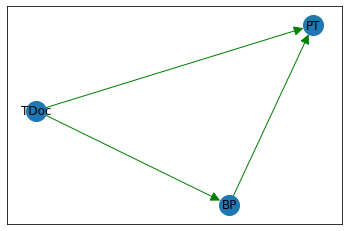

<Figure size 432x288 with 0 Axes>

In [26]:
macid3.draw_strategic_rel_graph()

The relevance graph for this example is acyclic, which enables quick and efficient computation of NE (see later)

We now instantiate a macid for our "triage" example (see my report)



In [27]:

def triage():
    from pgmpy.factors.discrete.CPD import TabularCPD
    macid = MACID([
        
        ('H1', 'D1'),  
        ('H1', 'U1'),
        
        ('H2', 'D2'),  
        ('H2', 'U2'),

        ('D1', 'U1'),
        ('D1', 'U2'),
        ('D1', 'U3'),
        ('D1', 'U4'),
        ('D1', 'U5'),
        ('D1', 'U6'),
        
        ('D1', 'D3'),
        ('D1', 'D4'),
        ('D1', 'D5'),
        ('D1', 'D6'),

        ('D2', 'U1'),
        ('D2', 'U2'),
        ('D2', 'U3'),
        ('D2', 'U4'),
        ('D2', 'U5'),
        ('D2', 'U6'),
        
        ('D2', 'D3'),
        ('D2', 'D4'),
        ('D2', 'D5'),
        ('D2', 'D6'),
        
        ('H3', 'D3'),  
        ('H3', 'U3'),
        
        ('H4', 'D4'),  
        ('H4', 'U4'),

        ('D3', 'U1'),
        ('D3', 'U2'),
        ('D3', 'U3'),
        ('D3', 'U4'),
        ('D3', 'U5'),
        ('D3', 'U6'),
        
        ('D3', 'D5'),
        ('D3', 'D6'),
        
        ('D4', 'U1'),
        ('D4', 'U2'),  
        ('D4', 'U3'),
        ('D4', 'U4'),  
        ('D4', 'U5'),
        ('D4', 'U6'),
        
        ('D4', 'D5'),
        ('D4', 'D6'),
                
        ('H5', 'D5'),  
        ('H5', 'U5'),
        
        ('H6', 'D6'),  
        ('H6', 'U6'),

        ('D5', 'U1'),
        ('D5', 'U2'),
        ('D5', 'U3'),
        ('D5', 'U4'),
        ('D5', 'U5'),
        ('D5', 'U6'),
        
        ('D6', 'U1'),
        ('D6', 'U2'),  
        ('D6', 'U3'),
        ('D6', 'U4'),
        ('D6', 'U5'),
        ('D6', 'U6'),

    
        ],
        {1: {'D': ['D1'], 'U': ['U1']}, 2: {'D': ['D2'], 'U': ['U2']}, \
         3: {'D': ['D3'], 'U': ['U3']}, 4: {'D': ['D4'], 'U': ['U4']}, \
         5: {'D': ['D5'], 'U': ['U5']}, 6: {'D': ['D6'], 'U': ['U6']}, \
         'C': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6']},     #defines the decisions, chance nodes and utility nodes for each agent
        )      

    return macid

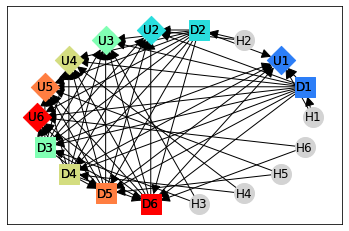

In [28]:
macid4 = triage()
macid4.draw()

Because of the complexity of the relationships between nodes in the macid, its structure is hard to interpret. However, we can use the macid's relevance graph to glean insights about the relationships between decision variables.

>Given a MACID, $\mathcal{M} = (N, \textbf{V}, E, \Theta)$, a set of nodes $\mathcal{S} \in \textbf{D}$ is a __strongly connected component (SCC)__ if there is a directed path between every pair of nodes $D \neq D' \in Rel(\mathcal{M})$. A __maximal SCC__ is an SCC that is not a strict subset of any other SCC. 

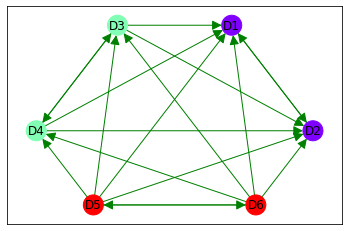

In [29]:
macid4.draw_SCCs()

The colour-coding partitions the decision nodes into their different SCCs. We see that we can break the overall problem into smaller sub-problems. For instance, although D5 and D6 rely on each other, they do not rely on any other nodes. 

When it comes to computing the NE of this macid, this means that we can first compute a best response policy equilibrium for D1 and D2 together (independent of the other decisions' policies) before proceeding to compute the equilibrium for D3 and D4 together and then finally to D1 and D2.

### 7) Identifying reasoning patterns in MACIDs:

### 8) Computing Nash Equilibria (acyclic relevance graph):

<div class="alert alert-block alert-info">
<b>Definition:</b> 
    A full policy profile $\pi$ is a <b>Nash Equilibrium (NE)</b> in a MACID $\mathcal{M}$} if for every player $i \in N$:
    
  $R^i_\mathcal{M}(\pi^{-i}, \pi^i) \geq R^i_\mathcal{M}(\pi^{-i}, \hat{\pi}^i) \: \forall \: \hat{\pi}^i \in \Pi^i.$
        
</div>   

<div class="alert alert-block alert-info">
<b>Algorithm (acyclic relevance graph):</b> 
Given a MACID, $\mathcal{M} = (N, \textbf{V}, E, \Theta)$, with a topological ordering $\prec \: = D_1,...,D_m$ over all decision nodes $\in Rel(\mathcal{M})$.
    
Let $\pi(0)$ be an initial arbitrary fully mixed policy profile for all nodes in $\mathcal{M}$.

For i = 1 to m: 
   - Let $\pi^*_{D_{i}}$ be the best response policy for $D_{i}$ using $\mathcal{M}(\pi_{-D_i}(i-1))$.
   - Let $\pi(i) = (\pi_{-D_{i}}(i-1),\pi^*_{D_{i}})$

Output $\pi(m)$ as the best response full policy profile (a Nash Equilibrium) of $\mathcal{M}$.
        
</div>   

__Election example__: 

_An incumbent president from a right-wing party runs is in an election against a challenger from a left-wing party. They must choose whether to release a manifesto aligning with their true ideology or shift their manifesto away from their ideology towards the centre. The president must decide on the politics of their manifesto first. If both choose to align with their ideology or both shift to the centre, the incumbent president wins, otherwise the challenger wins._

_In terms of utilty, assume that the value of winning is 2 and the value of comprimising on one's true ideology is -1. The net payoff is the sum of these two values._ 



In addition to defining the macid's graph, we now also want to add its parameterisation $\Theta$ (see CID and MACID definitions from earlier). We must define:

1. the domain of each utility variable
2. the conditional probability distributions (CPDs) for each variable:
    1. CPDs for chance nodes can be defined at the outset
    2. Decision  nodes  are  initialised  as NullCPDs. NullCPD takes the role of a placeholder as decision nodes are only assigned their conditional probability distributions through policies which are decided or computed later on.
    3. CPDs for the utility nodes must also be defined at the outset

The election example has no chance variables, but the description gives the utility CPDs for the president ($U_P$) and the challenger ($U_C$) to be:

<div>
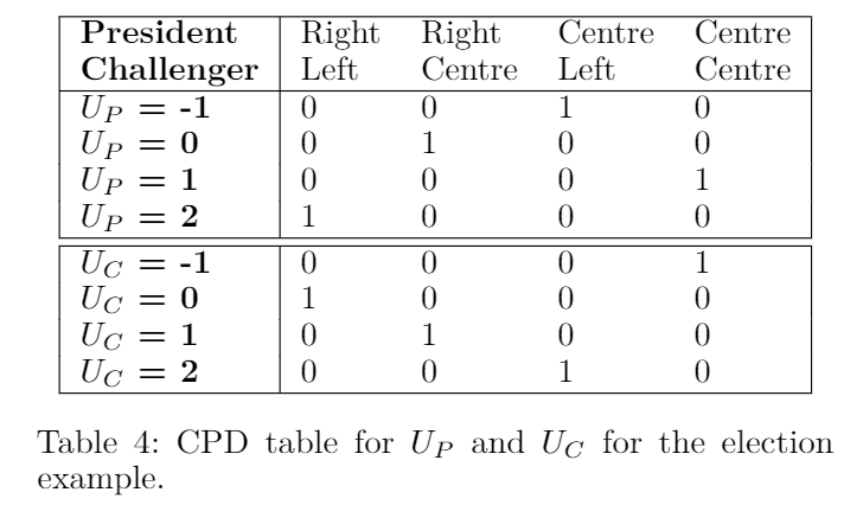
</div>



In [30]:
def election():
    from pgmpy.factors.discrete.CPD import TabularCPD
    macid = MACID([
        ('P', 'C'),
        ('P', 'U_C'),
        ('P', 'U_P'),
        ('C', 'U_P'),
        ('C', 'U_C'),
        ],
        {1: {'D': ['P'], 'U': ['U_P']}, 2: {'D': ['C'], 'U': ['U_C']}, 'C': []},  
        {'U_P':np.arange(-1,3), 'U_C':np.arange(-1,3)})     #the domain of each utility variable

    #cpd_chance = TabularCPD('chance',2,np.array([[.5],[.5]])) - if the macid has chance variables, they are defined at the outset.
    
    cpd_P = NullCPD('P', 2)  #initialising decision nodes as "NullCPDs"  (2 : the cardinality of the variable 'P')
    cpd_C = NullCPD('C', 2)

    U_P_cpd_array = np.array([[0, 0, 1, 0], #CPD for the president's utility 
                            [0, 1, 0, 0], 
                            [0, 0, 0, 1], 
                            [1, 0, 0, 0]])

    U_C_cpd_array = np.array([[0, 0, 0, 1], #CPD for the challenger's utility
                            [1, 0, 0, 0], 
                            [0, 1, 0, 0], 
                            [0, 0, 1, 0]])

    cpd_U_P = TabularCPD('U_P', 4, U_P_cpd_array, evidence=['P', 'C'], evidence_card=[2,2])
    # 'U_P' : the variable whose CPD is defined
    # 4 : the cardinality of 'U_P'
    # U_P_cpd_array : the values of the cpd table
    # evidence=['P', 'C'] : parents of the varaible in the macid (variables which matter wrst to this varaibles CPD)
    # evidence_card=[2,2] : cardinality of each of the parent varaibles 
    cpd_U_C = TabularCPD('U_C', 4, U_C_cpd_array, evidence=['P', 'C'], evidence_card=[2,2])

    macid.add_cpds(cpd_P, cpd_C, cpd_U_P, cpd_U_C) #addiing the CPDs to the macid

    return macid

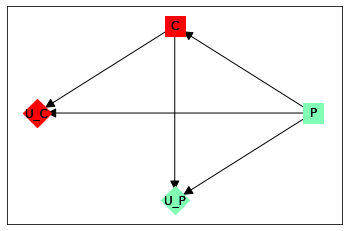

In [31]:
macid5 = election()
macid5.draw()

This example's extensive form game (EFG) looks like:

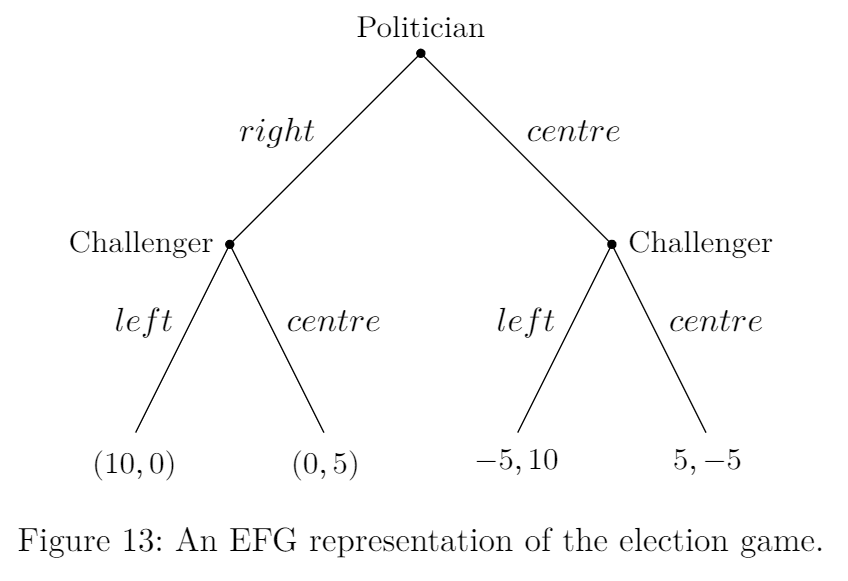

This macid has an acyclic relevance graph and so we can use the simpler algorithm (above) and explained in more detail in my report (link here)

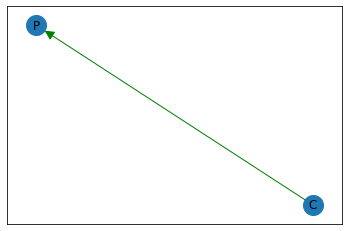

<Figure size 432x288 with 0 Axes>

In [32]:
macid5.draw_strategic_rel_graph()

To compute Nash equilibria (technically all pure-strategy perfect Bayesian equilibria - a refinement of Nash equilibria - see link)

In [33]:
macid5.get_all_PSNE()

Eliminating: U_P: 100%|██████████| 1/1 [00:00<00:00, 286.30it/s]

+------+-----+
| P(0) | 0.5 |
+------+-----+
| P(1) | 0.5 |
+------+-----+
+------+------+------+
| P    | P(0) | P(1) |
+------+------+------+
| C(0) | 0.5  | 0.5  |
+------+------+------+
| C(1) | 0.5  | 0.5  |
+------+------+------+



Eliminating: U_C: 100%|██████████| 1/1 [00:00<00:00, 55.77it/s]


[([], [('P', 0), ('C', 1)]),
 ([('P', 0)], [('P', 0), ('C', 1)]),
 ([('P', 1)], [('P', 1), ('C', 0)])]

The output (a list of tuples) should be read as follows to determine the Nash equilibria:

- The first tuple has an empty list as its first argument (we are performing no interventions on decision varaibles) and the second argument gives the decision choices each agent will make in this Nash Equilibirium (best response policy equilibrium).

For the other tuples:
- the first argument is a list describing the interventions on decision variables (in agreement with the acyclic topological ordering) and the second argument gives the best reponse to such an intevention by each of the other decision nodes.
    
For our election example:

From the first tuple, we read that in the (unique) Nash equilibirum of the election game, the president will select action '0' (remaining ideologically right wing) and the challenger will select action '1' (switching to the centre). The president will get a payoff of 0 because they will lose the election, but they don't have to compromise on their true ideology. The challenger will get a payoff of 1 because they will win the election, but they have to shift their manifesto to the centre in order to do so. 

From the other tuples, we are told what the challenger's best response policy is to whatever the president chooses. If the president is rational, they choose '0' (remaining right wing) and the challenger's best response is to choose '1' (switch to the centre). If the president chooses '1' (shifting to the centre), then the challenger's best response is to choose '0' (remaining left wing) to maximse their payoff. In this way, the challenger is making a "credible threat" towards the president. 

A Nash equilibirium is a full policy profile (see definition above) where no agent can gain an advantage by unilaterally deviating from this policy profile. This full policy profile $\pi$ is:

>- president = remain right-wing.
- challenger = switch to the centre if the president reamins right-wing, remain left-wing if the president switches to the centre.





### 9) Computing Nash Equilibria (cyclic relevance graph):


<div class="alert alert-block alert-info">
<b>Algorithm (cyclic relevance graph):</b> 
Given a MACID $\mathcal{M} = (N, \textbf{V}, E, \Theta)$, with a topological ordering $\prec \: = C_1,...,C_m$ over all maximal SCCs $\in Rel(\mathcal{M})$.

Let $\pi(0)$ be an initial arbitrary fully mixed policy profile for all decision nodes in $\mathcal{M}$. \\

For i = 1 to m:
   - Let $\pi^*_{C_{i}}$ be the best response policy profile for all decision nodes in $C_{i}$ using $\mathcal{M}(\pi_{-C_i}(i-1))$.
   - Let $\pi(i) = (\pi_{-C_{i}}(i-1),\pi^*_{C_{i}})$

    Output $\pi(m)$ as the best response policy profile (NE) of $\mathcal{M}$.}
        
</div>   

### 10) Transforming MACIDs into EFGs for use with GAMBIT